In [1]:
import copy

import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

from src.datasets import get_dataset
from src.visualization import (calculate_statistics, play_audio, plot_mfccs,
                               plot_specgram, plot_waveform,
                               visualize_random_sample)

## Problem Definition

## Dataset
LIBRISPEECH
LibriSpeech is a corpus of approximately 1000 hours of 16kHz read English speech, prepared by Vassil Panayotov with the assistance of Daniel Povey. The data is derived from read audiobooks from the LibriVox project, and has been carefully segmented and aligned.

Section contents:
- Visualize random sample
- Calculate dataset statistics

In [2]:
dataset_name = "librispeech"
dataset = get_dataset(dataset_name)

You're about to download librispeech with url dev-clean

 Done downloading


#### Visualizing data in random sample

waveform:  tensor([[0.0001, 0.0001, 0.0001,  ..., 0.0000, 0.0000, 0.0000]])
sample_rate:  16000
transcript:  UNDER CERTAIN CONDITIONS YOU MAY HEAR THE ROAR OF THE WATER RUSHING FROM THE ROCK AT A DISTANCE OF HALF A MILE OR EVEN MORE OR YOU MAY NOT HEAR IT UNTIL WITHIN A FEW RODS
speaker_id:  3000


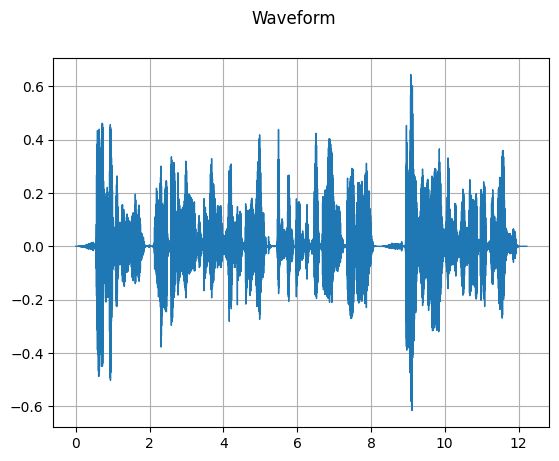

/home/renzo/anaconda3/envs/dl-env/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7688: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


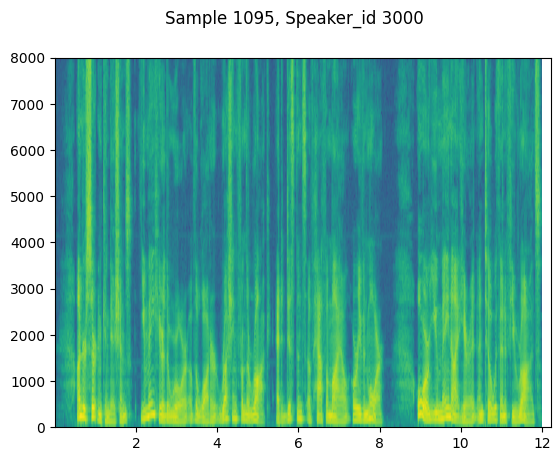

In [3]:
visualize_random_sample(dataset, plot_wave=True, plot_spectogram=True)

#### Calculate statistics in dataset

In [4]:
waveform_lengths = []
sample_rates = []
transcript_lengths = []
speaker_ids = []
audio_durations = []    

for i in range(dataset.__len__()):
    (waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id) = dataset.__getitem__(i)
    waveform_lengths.append(waveform[0].shape[0])
    sample_rates.append(sample_rate)
    transcript_lengths.append(len(transcript))
    speaker_ids.append(speaker_id)

    num_channels, num_frames = waveform.shape
    duration = num_frames / sample_rate
    audio_durations.append(duration)

dataset_stats = pd.DataFrame.from_dict(
{
    "waveform_lengths" : waveform_lengths,
    "sample_rates" : sample_rates,
    "transcript_lengths" : transcript_lengths,
    "audio_durations" : audio_durations,
}
    )

In [5]:
df_spkr = pd.DataFrame(columns=['speaker_id', 'duration'])
df_spkr['speaker_id'] = speaker_ids
df_spkr['duration'] = audio_durations

Because on average the duration of each speaker is 4.8 or higher, we decided to use a window_size of 4 seconds. Samples shorter than 4 seconds will be removed from the dataset

In [7]:
# df_spkr.groupby('speaker_id').mean().sort_values(by='duration', ascending=True)

Number of samples for each speaker

In [8]:
# df_spkr.groupby('speaker_id').size().sort_values()

In [9]:
# df = calculate_statistics(dataset)

## Preprocessing

In [10]:
sample_rate = 16000 # 16kHz
window_size = 4 * sample_rate # 1 second has 16000 samples, window_size is 4 seconds

batch_size = 10

train_pct = 0.70
val_pct = 0.20
test_pct = 0.10
number_spectral_coeffients = 13

We decided to normalize our data by using the mean and variance of the amplitude. The normalizer is fitted on the whole training set, not for each speaker. The reasoning for this is that in our problem, we do not know ahead of time who the speaker is.

In [11]:
def speaker_encoder(speaker_ids):
    speaker_dict = {}
    for i, speaker_id in enumerate(speaker_ids):
        speaker_dict[speaker_id] = i
        
    return speaker_dict

In [12]:
def split_waveform(waveform : np.array, window_size : int) -> list[np.array]:
    """
    Takes an original waveform and reduce to chunks of smaller intervals using a sliding window
    
    waveform : nd.array
    
    window_size : int
        window size in seconds
    
    Returns
    -------
    splitted_waveform : list[nd.array]
        list of waverforms
    
    """
    splitted_waveform = []
    
    for i in range(0, len(waveform), window_size):
        split = waveform[i:i+window_size]
        if len(split) == window_size:
            splitted_waveform.append(split)

    return splitted_waveform

def split_train_test_val(mfcc_dataset, train_pct, val_pct, test_pct):
    x = np.asarray(mfcc_dataset.mfcc_speaker_pairs, dtype=object)[:,0]
    y = np.asarray(mfcc_dataset.mfcc_speaker_pairs, dtype=object)[:,1]
    x_train, x_val_test, y_train, y_val_test = train_test_split(x, y, test_size=val_pct+test_pct, train_size=train_pct, shuffle=True)
    x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=test_pct/(val_pct+test_pct), train_size=val_pct/(val_pct+test_pct), shuffle=True)

    
    train_pairs = [[x_train[i], y_train[i]] for i in range(len(x_train))]
    val_pairs = [[x_val[i], y_val[i]] for i in range(len(x_val))]
    test_pairs = [[x_test[i], y_test[i]] for i in range(len(x_test))]
            
    return train_pairs, val_pairs, test_pairs

class CepstralNormalization:
    def __init__(self, number_spectral_coeffients : int):
        """
        """
        self.number_spectral_coeffients = number_spectral_coeffients
        self.mfcc_dataset = None
        self.mfcc_mean : list[float] | None = None
        self.mfcc_std : list[float] | None = None
    
    def fit(self, mfcc_dataset):
        """
        """
        columns = [f"x_{i}" for i in range(self.number_spectral_coeffients)]
        df_coeffs = pd.DataFrame(columns=columns)

        mfcc_mean = []
        mfcc_std = []

        j = 0
        for mfcc, _ in mfcc_dataset:
            for i in range(self.number_spectral_coeffients):
                df_coeffs.loc[j, f"x_{i}"] = mfcc[i,:]
            j += 1

        for i in range(self.number_spectral_coeffients):
            mfcc_mean.append(np.mean(np.hstack(df_coeffs[f"x_{i}"])))
            mfcc_std.append(np.std(np.hstack(df_coeffs[f"x_{i}"])))

        self.mfcc_mean, self.mfcc_std = mfcc_mean, mfcc_std
        
        return 
    
    def transform(self, mfcc_dataset):
        """
        """
        mfcc_dataset_copy = copy.deepcopy(mfcc_dataset)
        mfcc_speaker_pairs = np.array(mfcc_dataset_copy.mfcc_speaker_pairs, dtype='object')
        
        for sample in mfcc_speaker_pairs:
            for i in range(13):
                sample[0][i,:] = (sample[0][i,:] - self.mfcc_mean[i]) / self.mfcc_std[i]
        
        mfcc_dataset_copy.mfcc_speaker_pairs = mfcc_speaker_pairs
        
        return mfcc_dataset_copy

class MFCCData(Dataset):
    def __init__(self, dataset, window_size : int, sample_rate : int, speaker_dict : dict):
        """
        Creates a dataset of spectrograms from a dataset of waveforms
        
        train_test_val : str
            one of 'train', 'validation', or 'test'
        """
        self.dataset = dataset
        self.window_size = window_size        
        self.sample_rate = sample_rate
        self.speaker_dict = speaker_dict
        
        self.transform_to_mfcc()

    def transform_to_mfcc(self):
        """
        Transforms waveforms into MFCC spectrograms
        """
        self.mfcc_speaker_pairs = []
        
        for i in range(self.dataset.__len__()):
            (waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id) = self.dataset.__getitem__(i)
            waveform_arr = waveform.numpy().flatten()
            splitted_waveform = split_waveform(waveform_arr, self.window_size)
            
            for chunk in splitted_waveform:
                mfccs = librosa.feature.mfcc(y=chunk.flatten(), n_mfcc=13, sr=self.sample_rate)
                self.mfcc_speaker_pairs.append([mfccs, speaker_dict[speaker_id]])
            
    def __len__(self):
        return len(self.mfcc_speaker_pairs)

    def __getitem__(self, idx):
        waveform = self.mfcc_speaker_pairs[idx][0]
        speaker_id = self.mfcc_speaker_pairs[idx][1]
        return waveform, speaker_id

In [13]:
def get_datasets(base_dataset, speaker_dict : dict, window_size : int, sample_rate : int, train_pct : float, val_pct : float, test_pct : float, number_spectral_coeffients : int):
    """
    """
    try:
        mfcc_dataset_train, mfcc_dataset_val, mfcc_dataset_test = torch.load(f'mfcc_dataset_train_{train_pct}.pt'), torch.load(f'mfcc_dataset_val_{val_pct}.pt'), torch.load(f'mfcc_dataset_test_{test_pct}.pt') 
    
    except FileNotFoundError:
        mfcc_dataset = MFCCData(base_dataset, window_size=window_size, sample_rate=sample_rate, speaker_dict=speaker_dict)

        train_pairs, val_pairs, test_pairs = split_train_test_val(mfcc_dataset, train_pct, val_pct, test_pct)
        mfcc_dataset_train = copy.deepcopy(mfcc_dataset)
        mfcc_dataset_val = copy.deepcopy(mfcc_dataset)
        mfcc_dataset_test = copy.deepcopy(mfcc_dataset)
        mfcc_dataset_train.mfcc_speaker_pairs = train_pairs
        mfcc_dataset_val.mfcc_speaker_pairs = val_pairs
        mfcc_dataset_test.mfcc_speaker_pairs = test_pairs

        cepstral_normalization = CepstralNormalization(number_spectral_coeffients)

        cepstral_normalization.fit(mfcc_dataset_train)
        mfcc_dataset_train = cepstral_normalization.transform(mfcc_dataset_train)
        mfcc_dataset_val = cepstral_normalization.transform(mfcc_dataset_val)
        mfcc_dataset_test = cepstral_normalization.transform(mfcc_dataset_test)

        torch.save(mfcc_dataset_train, f'mfcc_dataset_train_{train_pct}.pt')
        torch.save(mfcc_dataset_val, f'mfcc_dataset_val_{val_pct}.pt')
        torch.save(mfcc_dataset_test, f'mfcc_dataset_test_{test_pct}.pt')

    return mfcc_dataset_train, mfcc_dataset_val, mfcc_dataset_test

In [15]:
speaker_dict = speaker_encoder(np.unique(df_spkr['speaker_id']))
mfcc_dataset_train, mfcc_dataset_val, mfcc_dataset_test = get_datasets(
                                                            dataset, 
                                                            speaker_dict=speaker_dict,
                                                            window_size=window_size, 
                                                            sample_rate=sample_rate, 
                                                            train_pct=train_pct,
                                                            val_pct=val_pct,
                                                            test_pct=test_pct,
                                                            number_spectral_coeffients=number_spectral_coeffients,
                                                            )

In [49]:
train_loader = DataLoader(mfcc_dataset_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(mfcc_dataset_val, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mfcc_dataset_test, batch_size=batch_size, shuffle=False)

In [54]:
mfcc_dataset_train.__len__(), mfcc_dataset_val.__len__(), mfcc_dataset_test.__len__(), 

(2399, 686, 343)

## Model Training

In [17]:
class FCN(nn.Module):
    def __init__(self, input_layers, hidden_layers, output_size):
        super(FCN, self).__init__()

        self.fc1 = nn.Linear(126 * 13, hidden_layers)
        self.fc2 = nn.Linear(hidden_layers, output_size)

    def forward(self, x):
        x = x.view(-1, 126 * 13)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [59]:
def evaluate(model, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_epoch = 0
    val_acc = []

    for i, data in enumerate(loader, 0):
        mfcc, speakers = data
        outputs = model(mfcc)
        
        loss = criterion(outputs, speakers)
        total_loss += loss.item()
        total_epoch += len(speakers)
        val_acc.append(get_accuracy(output=outputs, mfcc=mfcc, speakers=speakers))
        
    loss = float(total_loss) / (i + 1)
    val_acc = np.mean(val_acc)
    return loss, val_acc

def get_accuracy(output, mfcc, speakers):
    #select index with maximum prediction score
    correct = 0
    total = 0
    pred = output.max(1, keepdim=True)[1]
    correct += pred.eq(speakers.view_as(pred)).sum().item()
    total += mfcc.shape[0]
    return correct / total

def train_model(model, train_loader, val_loader, batch_size, num_epochs, criterion, optimizer, print_every=2, plot_loss=True):
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    train_acc = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    
    for epoch in range(num_epochs): 
        total_train_loss = 0.0
        total_epoch = 0
        total_train_acc = []
        correct = 0.0
        total = 0.0
        
        for i, data in enumerate(train_loader):
            mfcc, speakers = data
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass, backward pass, and optimize
            outputs = model(mfcc)
            loss = criterion(outputs, speakers)
            loss.backward()
            optimizer.step()
            
            # Calculate the statistics
            total_train_loss += loss.item()
            total_epoch += len(speakers)
            total_train_acc.append(get_accuracy(output=outputs, mfcc=mfcc, speakers=speakers))
            
        train_loss[epoch] = float(total_train_loss) / (i+1)
        train_acc[epoch] = np.mean(total_train_acc)        
        val_loss[epoch], val_acc[epoch] = evaluate(model, val_loader, criterion)
        
        if epoch % print_every == 0:    
            print(f"Epoch {epoch}: \n \
            Train loss {train_loss[epoch]:.3f} | Val loss {val_loss[epoch]:.3f} \n \
            Train acc {train_acc[epoch]:.3f} | Val acc {val_acc[epoch]:.3f} \n")
            
            
    if plot_loss:
        n = len(train_loss) # number of epochs
        plt.figure()
        plt.title("Train vs Validation Loss")
        plt.plot(range(1,n+1), train_loss, label="Train")
        plt.plot(range(1,n+1), val_loss, label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend(loc='best')
        # plt.show()

        plt.figure()
        plt.title("Train vs Validation Accuracy")
        plt.plot(range(1,n+1), train_acc, label="Train")
        plt.plot(range(1,n+1), val_acc, label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend(loc='best')   

In [60]:
model = FCN(200, 50, 40)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
num_epochs = 30

Epoch 0: 
             Train loss 1.114 | Val loss 0.436 
             Train acc 0.690 | Val acc 0.857 

Epoch 2: 
             Train loss 0.034 | Val loss 0.285 
             Train acc 0.992 | Val acc 0.932 

Epoch 4: 
             Train loss 0.002 | Val loss 0.263 
             Train acc 1.000 | Val acc 0.933 

Epoch 6: 
             Train loss 0.001 | Val loss 0.254 
             Train acc 1.000 | Val acc 0.932 

Epoch 8: 
             Train loss 0.001 | Val loss 0.253 
             Train acc 1.000 | Val acc 0.932 

Epoch 10: 
             Train loss 0.001 | Val loss 0.251 
             Train acc 1.000 | Val acc 0.932 

Epoch 12: 
             Train loss 0.001 | Val loss 0.249 
             Train acc 1.000 | Val acc 0.933 

Epoch 14: 
             Train loss 0.001 | Val loss 0.248 
             Train acc 1.000 | Val acc 0.933 

Epoch 16: 
             Train loss 0.000 | Val loss 0.248 
             Train acc 1.000 | Val acc 0.933 

Epoch 18: 
             Train loss 0.000 | Val loss

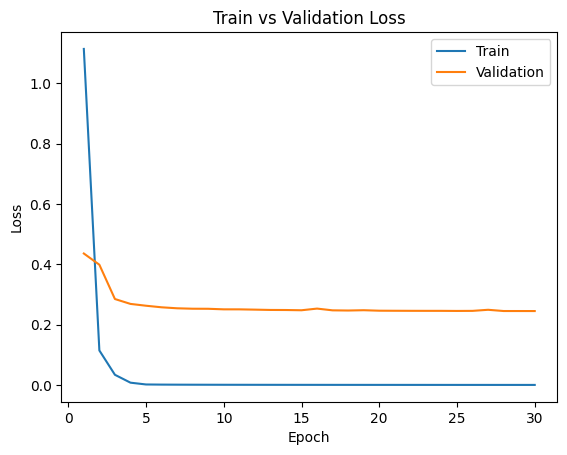

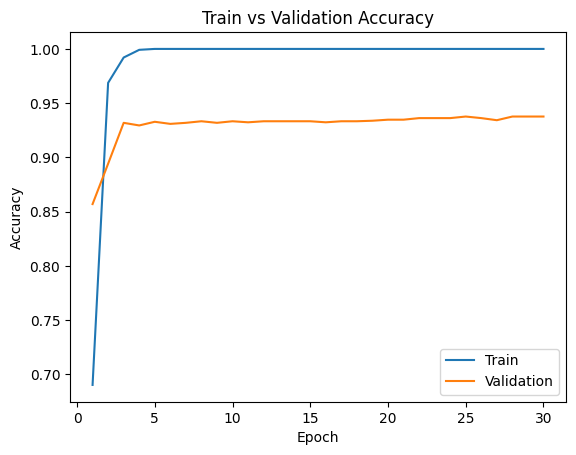

In [61]:
train_model(model, train_loader, val_loader, batch_size, num_epochs, criterion, optimizer, print_every=2)

In [64]:
def test_model(model, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            mfcc, speakers = data
            outputs = model(mfcc)
            _, predicted = torch.max(outputs.data, 1)
            total += speakers.size(0)
            correct += (predicted == speakers).sum().item()

    print(f'Accuracy: {100 * correct // total} %')

In [65]:
test_model(model, test_loader)

Accuracy: 94 %


In [68]:
for mfcc, speakers in test_loader:
    outputs = model(mfcc)
    _, predicted = torch.max(outputs.data, 1)
    print(f"predicted: {predicted}, actual: {speakers}")

predicted: tensor([36, 29, 13, 13, 23, 14,  7, 20, 34, 28]), actual: tensor([36, 29, 13, 13, 23, 14, 25, 20, 34, 28])
predicted: tensor([ 7, 15, 24, 29, 24, 14, 12,  9,  5,  0]), actual: tensor([ 7, 15, 24, 29, 24, 14, 12,  9,  5,  0])
predicted: tensor([ 1,  4, 33,  3, 32, 20, 38, 34,  0, 24]), actual: tensor([ 1,  4, 33,  3, 32, 20, 38, 34,  0, 24])
predicted: tensor([18,  9, 11,  6, 31, 20, 24, 17, 12, 20]), actual: tensor([24,  9,  7,  6, 31, 20, 24, 17, 12, 20])
predicted: tensor([ 5, 27,  1, 27,  8,  1, 38, 38,  5, 18]), actual: tensor([ 5, 27,  1, 27,  8, 15, 38, 38,  5, 18])
predicted: tensor([12, 17, 14, 30, 32,  0,  7, 26, 20, 26]), actual: tensor([12, 17, 14, 30, 32,  0,  7, 26, 20, 26])
predicted: tensor([22, 27,  0, 18,  8, 23, 25, 16,  2, 35]), actual: tensor([22, 27,  0, 18,  8, 23, 25, 16,  2, 35])
predicted: tensor([18, 38, 30, 33, 31, 32, 26, 19, 22, 27]), actual: tensor([18, 38, 30, 33, 31, 32, 26, 19, 22, 27])
predicted: tensor([28,  4, 24, 34,  6, 18, 31, 16, 30, 1